In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from parser_mit_dataset import to_swf

# Exploring the MIT Supercloud dataset
Some questions about:
- How easy is to covert it to the standard workloads format?
- What's different from the dataset I've been using?
- What's the same?

In [2]:
mit_raw = pd.read_csv("mit-logs.csv")
mit_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395914 entries, 0 to 395913
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id_job              395914 non-null  int64  
 1   id_array_job        395914 non-null  int64  
 2   id_array_task       395914 non-null  int64  
 3   id_user             395914 non-null  int64  
 4   kill_requid         395914 non-null  int64  
 5   nodes_alloc         395914 non-null  int64  
 6   nodelist            395914 non-null  object 
 7   cpus_req            395914 non-null  int64  
 8   derived_ec          395914 non-null  int64  
 9   exit_code           395914 non-null  int64  
 10  gres_used           0 non-null       float64
 11  array_max_tasks     395914 non-null  int64  
 12  array_task_pending  395914 non-null  int64  
 13  constraints         395914 non-null  object 
 14  flags               395914 non-null  int64  
 15  mem_req             395914 non-nul

In [ ]:
mit_raw['partition'].value_counts()

For us, the important jobs are from the CPU-only partition (Xeon Platinum 8260 CPU). I guess those jobs are marked as `xeon-p8` partition.

In [ ]:
mit_raw[['exit_code']].value_counts().head()

It's also important to only select those jobs with `exit_code` 0.

In [ ]:
mit_raw[mit_raw['exit_code'] == 0]

In [ ]:
mit_raw[mit_raw['timelimit'] == 4294967295]['job_type'].value_counts()

In [ ]:
mit_raw['constraints'][mit_raw['partition'] == 'xeon-p8'].value_counts()

The constraints field indicates the type of processor on which execute the job. This information is in accordance with the partition information.

In [ ]:
mit_raw['state'].value_counts() # Nothing meaningful here

## Standard workloads format equivalence
To convert the MIT Supercloud dataset to the standard workloads format, we need to:
- Filter the dataset to only select the CPU-only partition (Xeon Platinum 8260 CPU) and jobs with `exit_code` 0. (DONE)

| SWF                             | MIT Supercloud           |
|---------------------------------|--------------------------|
| Job Number                      | id_job                   |
| Submit Time                     | time_submit              |
| Wait Time                       | time_start - time_submit |
| Run Time                        | time_end - time_start    |
| Number of Allocated Processors  | -                        |
| Average CPU Time Used           | -                        |
| Used Memory                     | -                        |
| Requested Number of Processors  | cpus_req                 |
| Requested Time                  | timelimit                |
| Requested Memory                | mem_req                  |
| Status                          | -                        |
| User ID                         | id_user                  |
| Group ID                        | -                        |
| Executable (Application) Number | -                        |
| Queue Number                    | -                        |
| Partition Number                | -                        |
| Preceding Job Number            | -                        |
| Think Time from Preceding Job   | -                        |

In [3]:
mit_swf = to_swf(mit_raw)
mit_swf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393426 entries, 0 to 393425
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   Job number                       393426 non-null  int64 
 1   Submit time                      393426 non-null  int64 
 2   Wait time                        393426 non-null  int64 
 3   Run time                         393426 non-null  int64 
 4   Number of allocated processors   393426 non-null  int64 
 5   Average CPU time used            393426 non-null  int64 
 6   Used memory                      393426 non-null  int64 
 7   Requested number of processors   393426 non-null  int64 
 8   Requested time                   393426 non-null  int64 
 9   Requested memory                 393426 non-null  uint64
 10  Status                           393426 non-null  int64 
 11  User ID                          393426 non-null  int64 
 12  Group ID        

In [ ]:
mit_swf.head()

Seems we have enough data to use in our experiments.

## The time limit question

In [ ]:
mit_swf['Requested time'].value_counts()

In [ ]:
mit_swf[['User ID', 'Requested time']]

In [ ]:
# Group by Requested time and get the unique User ID
result = mit_swf[['User ID', 'Requested time']].groupby("Requested time")["User ID"].unique()
print(result)
# Reset the index and rename the columns
result = result.reset_index().rename(columns={"User ID": "Associated User ID"})
result

In [ ]:
strange_req_time = result[result["Requested time"] == 4294967295]
associated_user_ids = strange_req_time["Associated User ID"]
print(associated_user_ids.iloc[0].size)

283 users requested a time limit of 4294967295.

In [ ]:
unique_user_ids = mit_swf["User ID"].nunique()
print("Number of unique User IDs:", unique_user_ids)
user_ids_associated_with_strange_value = associated_user_ids.iloc[0].size
print("Fraction of User IDs associated with strange value:", user_ids_associated_with_strange_value / unique_user_ids)

## Checking the time unit

In [ ]:
req_times = pd.Series(mit_swf["Requested time"].unique())
print(req_times)

In [ ]:
req_times = pd.to_timedelta(req_times, unit="s")
print(req_times.sort_values().to_string())

## Large Requested time vs. Run time

In [ ]:
runtimes = mit_swf[['Run time', 'Requested time', 'Number of allocated processors']]
runtimes = runtimes[runtimes['Requested time'] == 4294967295]
print(runtimes)

In [ ]:
# Boxplot of the runtimes (without outliers)
plt.figure(figsize=(10, 5))
sns.boxplot(x="Run time", data=runtimes, showfliers=False)
plt.show()

# Boxplot of the runtimes just the outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x="Run time", data=runtimes, showfliers=True)
plt.show()

In [ ]:
# Histogram of the runtimes
plt.figure(figsize=(10, 5))
plt.hist(runtimes['Number of allocated processors'], bins=100000, histtype='stepfilled', color='steelblue', edgecolor='none')
plt.xlabel("Run time (s)")
plt.ylabel("Frequency")
plt.title("Histogram of runtimes")
plt.gca().set_xlim((0, 24))
plt.show()

In [ ]:
run_times.max()

In [5]:
import re

class ReaderSWF:
    def __init__(self, filename):
        self.filename = filename
        self.number_of_jobs = None
        self.number_of_processors = None
        self.jobs_info = {'p': [], '~p': [], 'q': [], 'r': []}
        self.read_and_extract_data()

    def read_and_extract_data(self):
        with open(self.filename, 'r') as reader:
            jobs_counter = 0
            for line in reader.readlines():
                
                row = re.split(" +", line.lstrip(" "))
                row[-1] = row[-1].rstrip()


                if row[0].startswith(";"):
                    if "MaxProcs:" in row:
                        self.number_of_processors = int(row[row.index("MaxProcs:") + 1])
                    elif "MaxNodes:" in row:
                        self.number_of_processors = int(row[row.index("MaxNodes:") + 1])
                    continue

                # row[4] is q, row[3] is p, row[8] is ~p, and row[1] is r
                if int(row[4]) > 0 and int(row[4]) <= self.number_of_processors and int(row[3]) > 0 and int(row[8]) > 0:
                    jobs_counter += 1
                    self.jobs_info['p'].append(int(row[3]))
                    self.jobs_info['~p'].append(int(row[8]))
                    self.jobs_info['q'].append(int(row[4]))
                    self.jobs_info['r'].append(int(row[1]))
            
            self.number_of_jobs = jobs_counter

In [6]:
reader = ReaderSWF("m_tsafrir05/mit-supercloud-est.swf")

In [7]:
tsafrir = reader.jobs_info['~p']

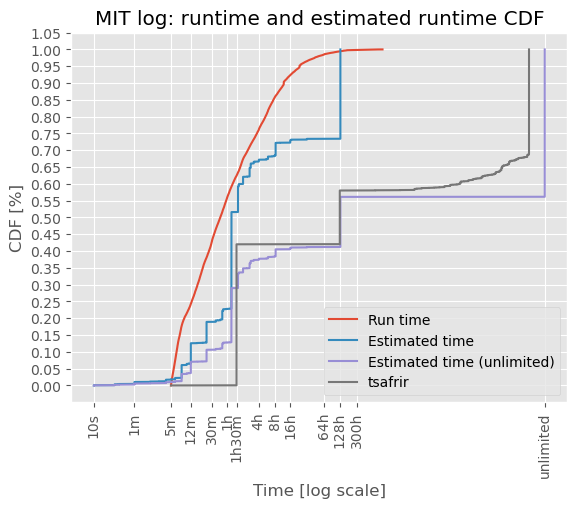

In [8]:
plt.style.use('ggplot')

# Get the run times
run_times = mit_swf["Run time"]
est_times = mit_swf[mit_swf['Requested time'] != 4294967295]['Requested time']
est_times_unlimited = mit_swf['Requested time']

# Calculate the cumulative distribution function
run_times_sorted = np.sort(run_times)
cdf = np.linspace(0, 1, len(run_times_sorted))

est_times_sorted = np.sort(est_times)
est_cdf = np.linspace(0, 1, len(est_times_sorted))

est_times_unlimited_sorted = np.sort(est_times_unlimited)
est_unlimited_cdf = np.linspace(0, 1, len(est_times_unlimited_sorted))

tsafrir_sorted = np.sort(tsafrir)
tsafrir_cdf = np.linspace(0, 1, len(tsafrir_sorted))

# Plot the cumulative distribution function
plt.plot(run_times_sorted, cdf)
plt.plot(est_times_sorted, est_cdf)
plt.plot(est_times_unlimited_sorted, est_unlimited_cdf)
plt.plot(tsafrir_sorted, tsafrir_cdf)
plt.xlabel("Time [log scale]")
plt.ylabel("CDF [%]")
plt.title("MIT log: runtime and estimated runtime CDF")
plt.xscale("log")
plt.legend(["Run time", "Estimated time", "Estimated time (unlimited)", "tsafrir"])

# Set the x-axis tick locations
tick_locations = [10, 60, 300, 720, 1800, 3600, 5400, 14400, 28800, 57600, 256000, 512000, 1080000, 4294967295]
tick_labels = ["10s", "1m", "5m", "12m", "30m", "1h", "1h30m", "4h", "8h", "16h", "64h", "128h", "300h", "unlimited"]
plt.xticks(tick_locations, tick_labels, rotation=90, ha='center', va='top')
# plt.gca().set_xlim((0, 57600))
# plt.gca().set_ylim((0, 1))
plt.yticks(np.arange(0, 1.1, 0.05))
plt.show()